In [1]:
import warnings
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import arviz as az
from  scipy.stats import iqr

# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
%pylab inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Populating the interactive namespace from numpy and matplotlib


Загрузим датасет с квартирами, проведём анализ данных и предобработку

In [2]:
DATADIR = './data/07'
data = pd.read_csv('/'.join([DATADIR, 'flats.csv']))
data.head()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0


Первый столбец не несёт никакой ценной информации.

Будем использовать:
- price_doc - цена квартиры
- full_sq - общая площадь квартиры
- life_sq - жилая площадь
- num_room - количество комнат
- kitch_sq - площадь кухни


In [3]:
data = data[['price_doc', 'full_sq', 'life_sq', 'num_room', 'kitch_sq']]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  6042 non-null   int64  
 1   full_sq    6042 non-null   int64  
 2   life_sq    6042 non-null   float64
 3   num_room   6042 non-null   float64
 4   kitch_sq   6042 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 236.1 KB


Датасет не содержит пропущенных значений

In [5]:
data.describe()

,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,9.512250e+07,637.000000,637.000000,17.000000,96.000000


Судя по всему, присутсвуют некорректные данные, так как есть записи с:
- общей площадью = 1
- с жилой = 0
- площадь кухни = 0 или 1
- количество комнат = 0

Отсеим на этапе анализа выбросов.

In [6]:
data[(data.full_sq == 1) | (data.life_sq == 0)]

,price_doc,full_sq,life_sq,num_room,kitch_sq
2256,13066000,1,1.0,1.0,1.0
2657,6675730,1,1.0,1.0,1.0
3773,14923206,1,47.0,1.0,1.0
4023,13452318,1,1.0,1.0,1.0
4461,17035200,1,1.0,1.0,1.0
5276,8758453,77,0.0,1.0,1.0


array([[<AxesSubplot:title={'center':'price_doc'}>,
        <AxesSubplot:title={'center':'full_sq'}>],
       [<AxesSubplot:title={'center':'life_sq'}>,
        <AxesSubplot:title={'center':'num_room'}>],
       [<AxesSubplot:title={'center':'kitch_sq'}>, <AxesSubplot:>]],
      dtype=object)

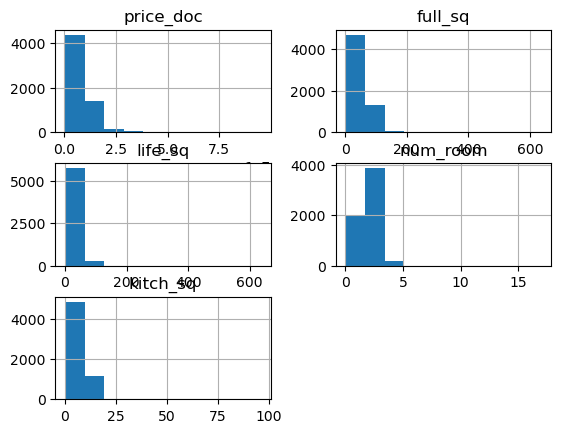

In [7]:
data.hist()

Распределение не нормальное. Улучшим с помощью отсеивания выбросов и логарифмирования.

<AxesSubplot:>

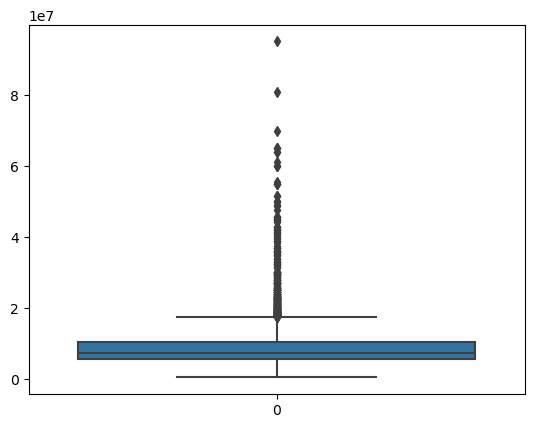

In [8]:
sns.boxplot(data['price_doc'])

<AxesSubplot:>

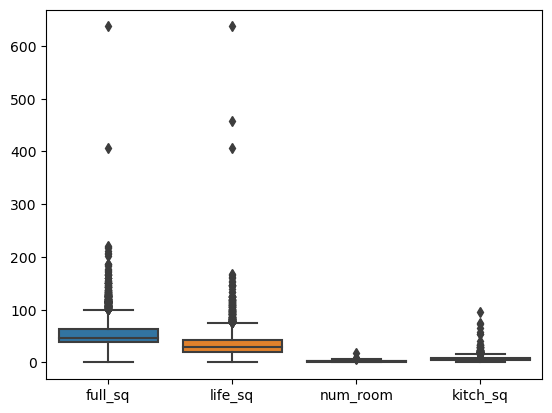

In [9]:
sns.boxplot(data[['full_sq', 'life_sq', 'num_room', 'kitch_sq']])

In [10]:
def get_bounds(series):
    """ Функция возвращает границы выбросов """
    series_iqr = iqr(series)
    upper = np.percentile(series, 75) + series_iqr
    bottom = np.percentile(series, 25) - series_iqr
    return (bottom, upper)

In [11]:
# Пройдёмся по всем колонкам, уберём выбросы, 
for column in data.columns:
    bottom, upper = get_bounds(data[column])
    data = data.loc[data[column].between(bottom, upper)]

In [12]:
# Прологарифмируем значение целевой переменной
data.price_doc = data.price_doc.apply(math.log)

array([[<AxesSubplot:title={'center':'price_doc'}>,
        <AxesSubplot:title={'center':'full_sq'}>],
       [<AxesSubplot:title={'center':'life_sq'}>,
        <AxesSubplot:title={'center':'num_room'}>],
       [<AxesSubplot:title={'center':'kitch_sq'}>, <AxesSubplot:>]],
      dtype=object)

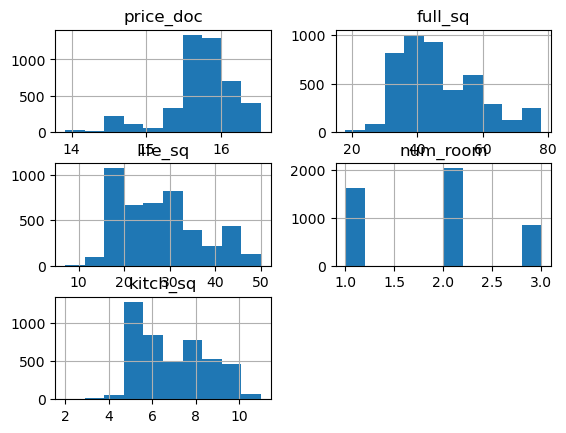

In [13]:
data.hist()

Построим модель байесовской линейной регрессии

In [14]:
# Контекст для модели
with pm.Model() as reg_model:
    
    # Априорная вероятность данных - нормальное распределение
    family = pm.glm.families.Normal()
    # Описываем формулу
    formula = 'price_doc ~ full_sq + life_sq + num_room + kitch_sq'
    
    # Обучаем модель
    pm.GLM.from_formula(formula, data = data, family = family)
    trace = pm.sample(draws=2000, chains = 2, tune = 500)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, kitch_sq, num_room, life_sq, full_sq, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 135 seconds.
The acceptance probability does not match the target. It is 0.956645799718236, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9931139704305174, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'full_sq'}>,
        <AxesSubplot:title={'center':'full_sq'}>],
       [<AxesSubplot:title={'center':'life_sq'}>,
        <AxesSubplot:title={'center':'life_sq'}>],
       [<AxesSubplot:title={'center':'num_room'}>,
        <AxesSubplot:title={'center':'num_room'}>],
       [<AxesSubplot:title={'center':'kitch_sq'}>,
        <AxesSubplot:title={'center':'kitch_sq'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

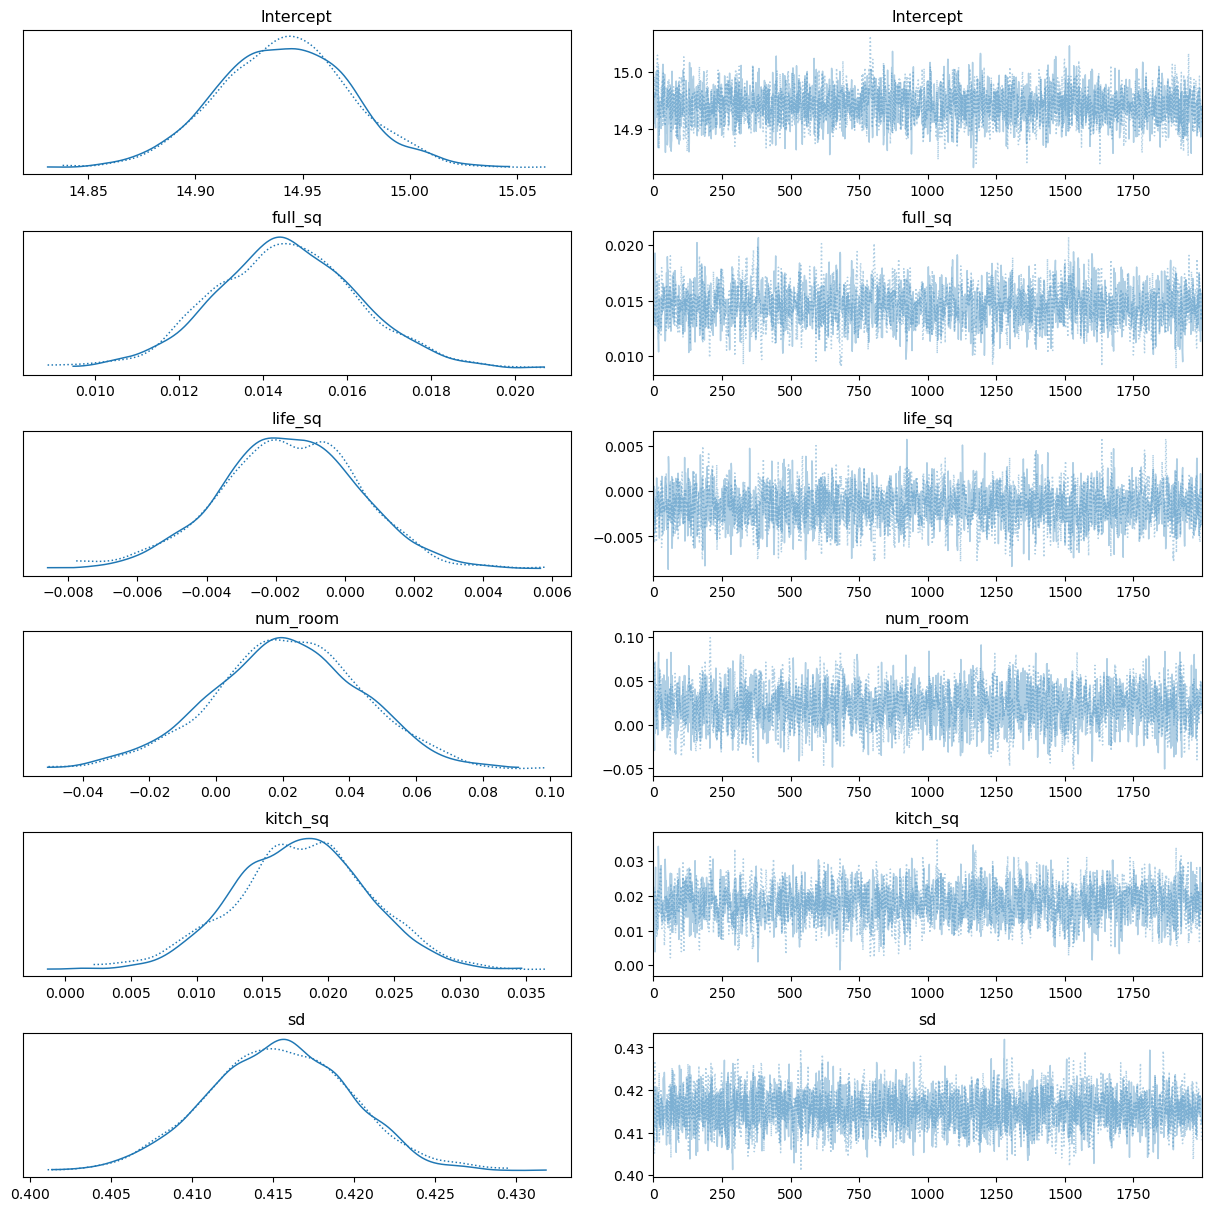

In [15]:
az.plot_trace(trace)

<Figure size 900x700 with 0 Axes>

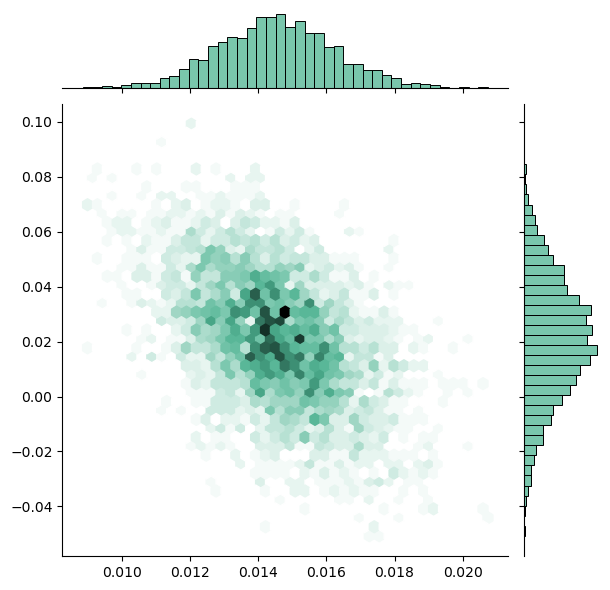

In [16]:
plt.figure(figsize=(9, 7))
sns.jointplot(x=trace["full_sq"], y=trace["num_room"], kind="hex", color="#4CB391")

Посмотрим на статистику и сравним с LinearRegression от sklearn

In [17]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,14.941,0.031,14.882,14.999,0.001,0.0,2485.0,1865.0,1.0
full_sq,0.015,0.002,0.012,0.018,0.000,0.0,1737.0,1933.0,1.0
life_sq,-0.002,0.002,-0.006,0.002,0.000,0.0,2125.0,2322.0,1.0
num_room,0.021,0.022,-0.020,0.065,0.001,0.0,1831.0,1668.0,1.0
kitch_sq,0.018,0.005,0.009,0.028,0.000,0.0,1874.0,2206.0,1.0
sd,0.415,0.004,0.407,0.423,0.000,0.0,3000.0,2551.0,1.0


Построим линейную регрессию sklearn

In [18]:
linreg = LinearRegression()
linreg.fit(data[['full_sq', 'life_sq', 'num_room', 'kitch_sq']], data['price_doc'])

LinearRegression()

In [19]:
print(linreg.intercept_)
pd.DataFrame(linreg.coef_, index=['full_sq', 'life_sq', 'num_room', 'kitch_sq'])

14.940947396621926


,0
full_sq,0.014567
life_sq,-0.001647
num_room,0.021037
kitch_sq,0.017920


In [20]:
# Сравним результат
df = pd.DataFrame(linreg.coef_, index=['full_sq', 'life_sq', 'num_room', 'kitch_sq'])
df['mean'] = pd.DataFrame(pm.summary(trace))['mean']
df.columns = ['Sklearn', 'Bayes']

df['diff'] = abs(df['Sklearn'] - df['Bayes'])
df

,Sklearn,Bayes,diff
full_sq,0.014567,0.015,0.000433
life_sq,-0.001647,-0.002,0.000353
num_room,0.021037,0.021,0.000037
kitch_sq,0.017920,0.018,0.000080


Вывод: В результате мы получили близкий результат. Но ради справедливости стоит отметить, что в данном случае Линейная регрессия sklearn работает значительно быстрее.